<a href="https://colab.research.google.com/github/22anushka/Green-Vehicle-Routing-Problem/blob/main/GVRP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
@author Asmi S, Dhakshina R, Anushka S
```



# Installing Libraries

In [ ]:
!pip install -q pulp

In [ ]:
from pulp import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn

# Loading the Dataset

In [ ]:
sites = ['Barcelona','Belgrade','Berlin','Brussels','Bucharest','Budapest','Copenhagen','Dublin','Hamburg','Istanbul','Kiev',
         'London','Madrid','Milan','Moscow','Munich','Paris','Prague','Rome','Saint Petersburg','Sofia','Stockholm','Vienna','Warsaw']
latlng = ['latitude', 'longitude']
position = pd.read_csv('/content/position.csv', index_col="City")
flighttime = pd.read_csv('/content/flight_time.csv', index_col="City")
distance = pd.read_csv('/content/distance.csv', index_col="City")

In [ ]:
print(position)

                  latitude  longitude
City                                 
Barcelona          41.3888     2.1590
Belgrade           44.8040    20.4651
Berlin             52.5244    13.4105
Brussels           50.8505     4.3488
Bucharest          44.4323    26.1063
Budapest           47.4980    19.0399
Copenhagen         55.6759    12.5655
Dublin             53.3331    -6.2489
Hamburg            53.5753    10.0153
Istanbul           41.0138    28.9497
Kiev               50.4547    30.5238
London             51.5085    -0.1257
Madrid             40.4165    -3.7026
Milan              45.5928    12.1728
Moscow             55.7522    37.6156
Munich             48.1374    11.5755
Paris              48.8534     2.3488
Prague             50.0880    14.4208
Rome               41.8919    12.5113
Saint Petersburg   59.9386    30.3141
Sofia              42.6975    23.3241
Stockholm          59.3326    18.0649
Vienna             48.2085    16.3721
Warsaw             52.2298    21.0118


In [ ]:
print(flighttime)

                  Barcelona  Belgrade  Berlin  Brussels  Bucharest  Budapest  \
City                                                                           
Barcelona                 0       379     373       336        416       383   
Belgrade                379         0     326       361        274       270   
Berlin                  373       326       0       291        349       305   
Brussels                336       361     291         0        394       347   
Bucharest               416       274     349       394          0       295   
Budapest                383       270     305       347        295         0   
Copenhagen              397       355     261       301        373       333   
Dublin                  372       433     352       305        465       418   
Hamburg                 369       345     145       273        369       324   
Istanbul                444       312     395       436        273       339   
Kiev                    455       323   

In [ ]:
print(distance)

                  Barcelona  Belgrade   Berlin  Brussels  Bucharest  Budapest  \
City                                                                            
Barcelona              0.00   1528.13  1497.61   1062.89    1968.42   1498.79   
Belgrade            1528.13      0.00   999.25   1372.59     447.34    316.41   
Berlin              1497.61    999.25     0.00    651.62    1293.40    689.06   
Brussels            1062.89   1372.59   651.62      0.00    1769.69   1131.52   
Bucharest           1968.42    447.34  1293.40   1769.69       0.00    639.77   
Budapest            1498.79    316.41   689.06   1131.52     639.77      0.00   
Copenhagen          1757.54   1327.24   354.03    766.67    1571.54   1011.31   
Dublin              1469.29   2145.39  1315.16    773.20    2534.72   1894.95   
Hamburg             1471.78   1229.93   254.51    489.76    1544.17    927.92   
Istanbul            2230.42    809.48  1735.01   2178.85     445.62   1064.76   
Kiev                2391.06 

# Forming Emissions Matrix
We calculate the cost of every edge as the amount of emissions output by travelling it:


> emissions = EF * d

where EF = 429.51 - 7.8227 x speed + 0.0617 x (speed^2)



In [ ]:
#Calculating speed matrix
speed = distance/flighttime
speed = speed.fillna(0)

In [ ]:
EF = 429.51 - 7.8227*speed + 0.0617*(speed**2)
emissions = EF.mul(distance)

In [ ]:
print(emissions)

                     Barcelona       Belgrade         Berlin       Brussels  \
City                                                                          
Barcelona         0.000000e+00  609680.919348  597690.434205  430875.818338   
Belgrade          6.096809e+05       0.000000  405807.094277  549939.981647   
Berlin            5.976904e+05  405807.094277       0.000000  268664.517940   
Brussels          4.308758e+05  549939.981647  268664.517940       0.000000   
Bucharest         7.753137e+05  186497.344496  519127.252450  700121.807537   
Budapest          5.992797e+05  133027.433271  283997.300756  457877.834456   
Copenhagen        6.961400e+05  532390.041496  148343.004261  314323.407077   
Dublin            5.870918e+05  841562.402134  527568.204028  317070.251356   
Hamburg           5.876674e+05  494931.367395  105868.362598  203580.845670   
Istanbul          8.738115e+05  331586.831225  687653.412996  854017.702004   
Kiev              9.327645e+05  396688.940905  48480

# Plotting the Nodes

In [ ]:
positions = dict( ( city, (position.loc[city, 'longitude'], position.loc[city, 'latitude']) ) for city in sites)

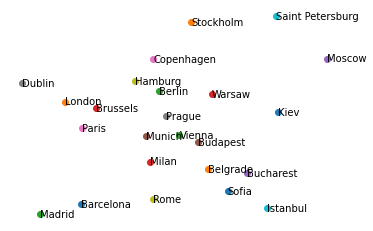

In [ ]:
for s in positions:
    p = positions[s]
    plt.plot(p[0],p[1],'o')
    plt.text(p[0]+.01,p[1],s,horizontalalignment='left',verticalalignment='center')

plt.gca().axis('off');

# Formulating the Problem
The problem is to minimise the emissions output for all routes formed. The number of routes to be formed is denoted by K.

In [ ]:
#Get the distance between cities
distances = dict( ((s1,s2), emissions.loc[s1, s2] ) for s1 in positions for s2 in positions if s1!=s2)

In [ ]:
#Setting the number of routes to be formed
K = 3

In [ ]:
#Setting the starting point
starting_node = 'Berlin'

In [ ]:
#Create the problem
prob = LpProblem("vehicle", LpMinimize)

In [ ]:
#Variable to indicate if site i is connected to site j in the tour
x = LpVariable.dicts('x', distances, 0, 1, LpBinary)
#Dummy variables to eliminate subtours
u = LpVariable.dicts('u', sites, 0, len(sites)-1, LpInteger)

In [ ]:
#Defining the objective and adding costs to the problem
cost = lpSum([x[(i,j)]*distances[(i,j)] for (i,j) in distances])
prob += cost

In [ ]:
#Adding constraints
for k in sites:
    cap = 1 if k != starting_node else K
    #Defining number of inbound connections for each node
    prob += lpSum([x[(i,k)] for i in sites if (i,k) in x]) == cap
    #Defining number of outbound connections for each node
    prob += lpSum([x[(k,i)] for i in sites if (k,i) in x]) == cap

#Subtour elimination constraints
N = len(sites)/K
for i in sites:
    for j in sites:
        if i != j and (i != starting_node and j != starting_node) and (i,j) in x:
            prob += u[i] - u[j] <= (N)*(1-x[(i,j)]) - 1

In [ ]:
prob

vehicle:
MINIMIZE
609680.9193477259*x_('Barcelona',_'Belgrade') + 597690.4342049643*x_('Barcelona',_'Berlin') + 430875.8183379433*x_('Barcelona',_'Brussels') + 775313.7109182018*x_('Barcelona',_'Bucharest') + 599279.7479828602*x_('Barcelona',_'Budapest') + 696140.0449801091*x_('Barcelona',_'Copenhagen') + 587091.8137050807*x_('Barcelona',_'Dublin') + 587667.3687653189*x_('Barcelona',_'Hamburg') + 873811.4811128671*x_('Barcelona',_'Istanbul') + 932764.4772693831*x_('Barcelona',_'Kiev') + 459894.3102372189*x_('Barcelona',_'London') + 205806.38371773146*x_('Barcelona',_'Madrid') + 298744.42803541437*x_('Barcelona',_'Milan') + 1164709.6605763999*x_('Barcelona',_'Moscow') + 429008.4770319397*x_('Barcelona',_'Munich') + 340360.0859352141*x_('Barcelona',_'Paris') + 543070.5871515459*x_('Barcelona',_'Prague') + 350286.3965767136*x_('Barcelona',_'Rome') + 1090360.1309968866*x_('Barcelona',_'Saint_Petersburg') + 691491.7952321013*x_('Barcelona',_'Sofia') + 890167.5321205872*x_('Barcelona',_'Stoc

# Solving the Problem
The 'x' dictionary is updated during problem solving. Entry 1 for node pair (i, j) indicates that the edge between i and j exists in the solution. Entry 0 indicates exclusion of the edge from the solution.

In [ ]:
%time prob.solve()
print(LpStatus[prob.status])

CPU times: user 1.42 s, sys: 184 ms, total: 1.61 s
Wall time: 4min 44s
Optimal


In [ ]:
for i in x:
  print(value(x[i]))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0


# Translating the Solution
The solution is currently just a dictionary filled with 0s and 1s. This data needs to be translated into human readable routes.

In [ ]:
non_zero_edges = [ e for e in x if value(x[e]) != 0 ]

def get_next_site(parent):
    #Helper function to get the next edge
    edges = [e for e in non_zero_edges if e[0] == parent]
    for e in edges:
        non_zero_edges.remove(e)
    return edges

In [ ]:
tours = get_next_site(starting_node)

In [ ]:
tours = [ [e] for e in tours ]

In [ ]:
for t in tours:
  while t[-1][1] != starting_node:
      t.append(get_next_site(t[-1][1])[-1])

In [ ]:
#Printing the generated routes
for t in tours:
    print(' -> '.join([a for a,b in t]+[starting_node]))

Berlin -> Brussels -> Paris -> London -> Dublin -> Madrid -> Barcelona -> Milan -> Munich -> Berlin
Berlin -> Rome -> Sofia -> Istanbul -> Bucharest -> Belgrade -> Budapest -> Vienna -> Prague -> Berlin
Berlin -> Warsaw -> Kiev -> Moscow -> Saint Petersburg -> Stockholm -> Copenhagen -> Hamburg -> Berlin


In [ ]:
#Calculating total time needed to traverse all routes parallely
totalTime = 0;
for t in tours:
    time = 0
    for i in range(0, len(t)):
        time += flighttime.loc[t[i][0], t[i][1]]
    if time > totalTime:
        totalTime = time
print(totalTime)

2546


# Final Solution

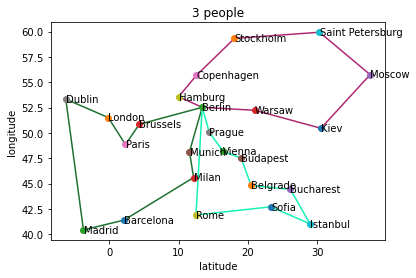

In [ ]:
#Plotting the tours
colors = [np.random.rand(3) for i in range(len(tours))]
for t,c in zip(tours,colors):
    for a,b in t:
        p1,p2 = positions[a], positions[b]
        plt.plot([p1[0],p2[0]],[p1[1],p2[1]], color=c)

for s in positions:
    p = positions[s]
    plt.plot(p[0],p[1],'o')
    plt.text(p[0]+.01,p[1],s,horizontalalignment='left',verticalalignment='center')

plt.title('%d '%K + 'people' if K > 1 else 'person')
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.show()

In [ ]:
print('Longest time spent in route traversal:', totalTime, '(min)')
print('Total emissions during traversal:', value(prob.objective)/1000, '(kg)')

Longest time spent in route traversal: 2546 (min)
Total emissions during traversal: 5815.184188561756 (kg)
